In [1]:
# Setup
import json
import websocket
import os

import pandas as pd
import numpy as np
import cufflinks as cf
import plotly.graph_objects as go

from plotly.subplots import make_subplots

from datetime import datetime


UserName = "gabrielpehls@hotmail.com"
Password = "Kaleb;171219m;"

nextIvalue = 0

def call_service(ws, service_name, data, level=0):
    global nextIvalue
    frame = {
        'm': level,
        'i': nextIvalue,
        'n': service_name,
        'o': json.dumps(data)
    }
    nextIvalue += 2
    ws.send(json.dumps(frame))

def on_error(ws, error):
    print(error)
    
def show_info(ws, data):
    print(data)
    ws.close()
    return data
    
def get_info(ws, data):
    ws.on_message = show_info
    call_service(ws, 'GetUserInfo', {})


def start_talking(ws):
    ws.on_message = get_info
    call_service(ws, 'WebAuthenticateUser', {
        'UserName': UserName,
        'Password': Password
    })

#### Websocket
##### Subscribes, por exemplo

In [100]:
nextIvalue = 0
global endpoint
endpoint = "SubscribeTicker"

def show_info_json(ws, data_string):
    data = json.loads(data_string)
    #print(data['o'])
    if (nextIvalue > 0):
        convert_n_save(data['o'])
    
    
def start_talking_endpoint(ws):
    ws.on_message = show_info_json
    call_service(ws, endpoint, {
        "OMSId": 1, 
        "InstrumentId": 1, # BTCBRL
        "Interval": 300,    # 60s
        "IncludeLastCount": 1
    })
    
def convert_n_save(data):
    data = [data.replace("[[","").replace("]]","").split(",")]
    df = pd.DataFrame(data = data, columns = ['EndDateTime','High','Low','Open','Close','Volume','Bid','Ask','InstrumentId', 'BeginDateTime'])
    df.EndDateTime = datetime.fromtimestamp(float(df.EndDateTime) / 1000).strftime('%Y-%m-%d %H:%M:%S')
    df.BeginDateTime = datetime.fromtimestamp(float(df.BeginDateTime) / 1000).strftime('%Y-%m-%d %H:%M:%S')
    path = "BTCBRL.csv"
    if (os.path.isfile(path)):
        df = df.append(pd.read_csv(path, sep=";"))
    df.to_csv(path, sep=";", index=False)
    #generate_graph()
    
def generate_graph(df):
    INCREASING_COLOR = '#17BECF'
    DECREASING_COLOR = '#7F7F7F'

    path = "BTCBRL.csv"

    df = pd.read_csv(path, sep=";").drop_duplicates()
    df.index = df.Datetime

    fig = make_subplots(rows=2, cols=1)
    fig = fig.add_trace(go.Candlestick(x=df.index,
                                       open=df['Open'],
                                       high=df['High'],
                                       low=df['Low'],
                                       close=df['Close']),
                        row=1, col=1
                       )
    fig = fig.update_layout(xaxis_rangeslider_visible=False)
    # volume bar chart

    colors = []

    for i in range(len(df.Close)):
        if i != 0:
            if df.Close[i] > df.Close[i-1]:
                colors.append(INCREASING_COLOR)
            else:
                colors.append(DECREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)


    # add to graph
    fig.add_trace(
        go.Bar(x=df.index, y=df.Volume,
               #marker=dict(color=colors),#
               name='Volume'),
        row=2, col=1

    )
    fig.show()

In [101]:
websocket.enableTrace(False)
ws = websocket.WebSocketApp('wss://api.coinext.com.br/WSGateway/',
                            on_error=on_error,
                            on_message=show_info_json,
                            on_open=start_talking_endpoint)
ws.run_forever()

False

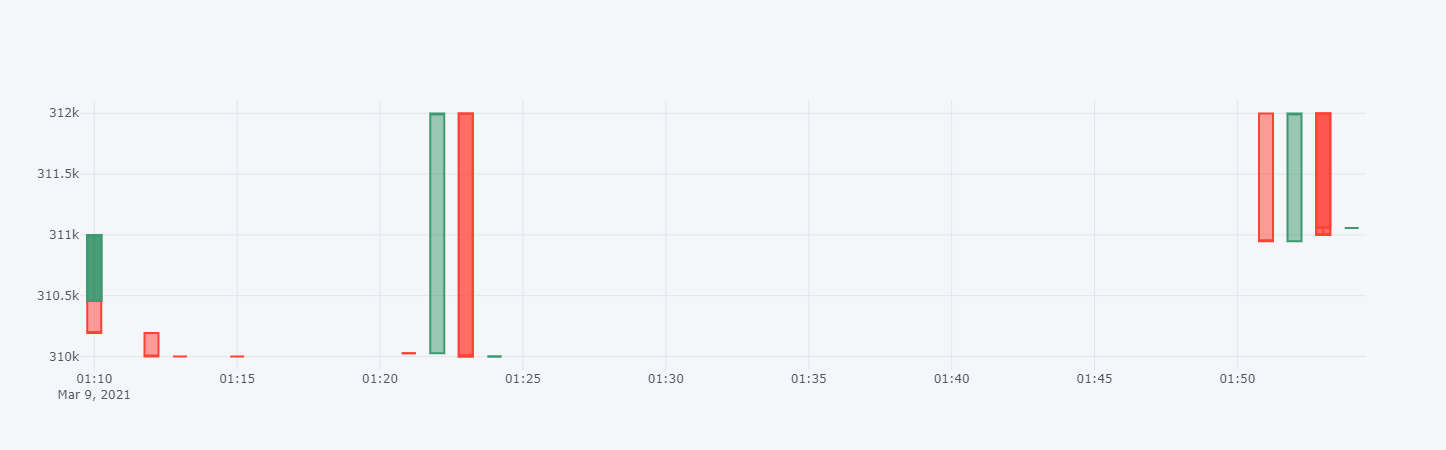

In [93]:
# ver https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-python-mplfinance-plotly-bokeh

cf.set_config_file(theme='pearl',sharing='public',offline=True)

df.iplot(kind="candle", keys=["Open","High", "Low", "Close"])
